# Austin TX Bike Explanatory Analysis

In this notebook I have listed out steps how you can do explanatory analysis on the data using BigQuery, Pandas and Matplot lib. For this analysis I have chosen Austin Bike public dataset from BiqQuery. 

### Authenticate BQ

Once you run this cell you will be prompted with Authorization key and you can get it once you authenticate yourself with your Google Cloud Platform.

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


Initialize the Variables and also get handle to python BQ client object

In [2]:
project_id = '{Enter your project_id}'
api_key = '{Enter your Google Maps API Key here}'

from google.cloud import bigquery
import matplotlib.pyplot as plt
client = bigquery.Client(project=project_id)

#### Bike Share Stations Analysis

Get the bikeshare stations from BigQuery. Since this table is not big and that's why we are querying all the data.

In [3]:


bike_share_stations_df = client.query('''
  SELECT
    *
  FROM
    `bigquery-public-data.austin_bikeshare.bikeshare_stations`''').to_dataframe()

Check the sample rows for stations and from this data we can see what stations are active and where they are located.

In [4]:
bike_share_stations_df.head()

,station_id,name,status,latitude,longitude,location
0,3793,Rio Grande & 28th,active,30.29333,-97.74412,"(30.29333, -97.74412)"
1,3291,11th & San Jacinto,active,30.27193,-97.73854,"(30.27193, -97.73854)"
2,4058,Hollow Creek & Barton Hills,active,30.26139,-97.77234,"(30.26139, -97.77234)"
3,3797,21st & University,active,30.28354,-97.73953,"(30.28354, -97.73953)"
4,3838,Nueces & 26th,active,30.29068,-97.74292,"(30.29068, -97.74292)"


We want to Visualize the active & closed stations with Pie Chart. Following code does exactly what we are looking for.

['active' 'closed']


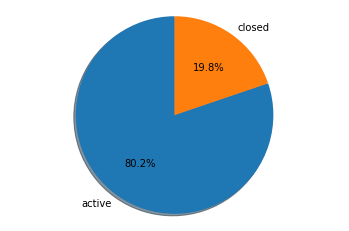

In [5]:

status_labels = bike_share_stations_df['status'].unique()
print(status_labels)
sizes = []
for status_label in status_labels:
  sizes.append(len(bike_share_stations_df[bike_share_stations_df['status'] == status_label]))
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=status_labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

#### Bike share trips

Now we want to look at the Bike Share Trips. For this we want to get the 2000 samples. Here is the query to do this

In [6]:
from google.cloud import bigquery

sample_count = 2000
bike_share_trips_total_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`''').to_dataframe().total[0]

df = client.query('''
  SELECT
    *
  FROM
    `bigquery-public-data.austin_bikeshare.bikeshare_trips`
  WHERE RAND() < %d/%d
''' % (sample_count, bike_share_trips_total_count)).to_dataframe()

print('Full dataset has %d rows' % bike_share_trips_total_count)

Full dataset has 1264113 rows


In [7]:
df.head()

,trip_id,subscriber_type,bikeid,start_time,start_station_id,start_station_name,end_station_id,end_station_name,duration_minutes
0,9900304407,Local365,995,2015-10-16 19:12:44+00:00,1008.0,Nueces @ 3rd,1008,Nueces @ 3rd,2
1,9900328225,Walk Up,113,2015-11-13 14:12:15+00:00,2536.0,Waller & 6th St.,2536,Waller & 6th St.,0
2,9900332316,Walk Up,348,2015-11-22 15:12:37+00:00,2823.0,Capital Metro HQ - East 5th at Broadway,2823,Capital Metro HQ - East 5th at Broadway,32
3,9900349651,Local365,575,2015-12-21 08:12:09+00:00,2536.0,Waller & 6th St.,1007,Lavaca & 6th,7
4,14541244,Walk Up,370,2017-04-22 14:56:06+00:00,3294.0,Guadalupe & 6th,3294,Guadalupe & 6th,23


We looked at the bike share sample trips data and now we want to know Top 10 bike subscribers


In [8]:
top10_subscribers = client.query('''SELECT
  DISTINCT subscriber_type,
  COUNT(*) subscrber_count
FROM
  `bigquery-public-data.austin_bikeshare.bikeshare_trips`
WHERE
  subscriber_type IS NOT NULL
  and end_station_id not in ('Event')
  and start_station_id in (select distinct station_id from `bigquery-public-data.austin_bikeshare.bikeshare_stations` where status = 'active')
  and CAST(end_station_id as INT64) in (select distinct station_id from `bigquery-public-data.austin_bikeshare.bikeshare_stations` where status = 'active')
GROUP BY
  subscriber_type
ORDER BY
  subscrber_count DESC
limit 10''').to_dataframe()

In [9]:
top10_subscribers

,subscriber_type,subscrber_count
0,Walk Up,319759
1,U.T. Student Membership,277159
2,Local365,178750
3,24-Hour Kiosk (Austin B-cycle),73224
4,Local30,58465
5,Weekender,40784
6,Explorer,24296
7,24 Hour Walk Up Pass,22639
8,Annual Membership (Austin B-cycle),21539
9,Local365+Guest Pass,13253


Lets Visualize top 10 subscribers with Bar Chart

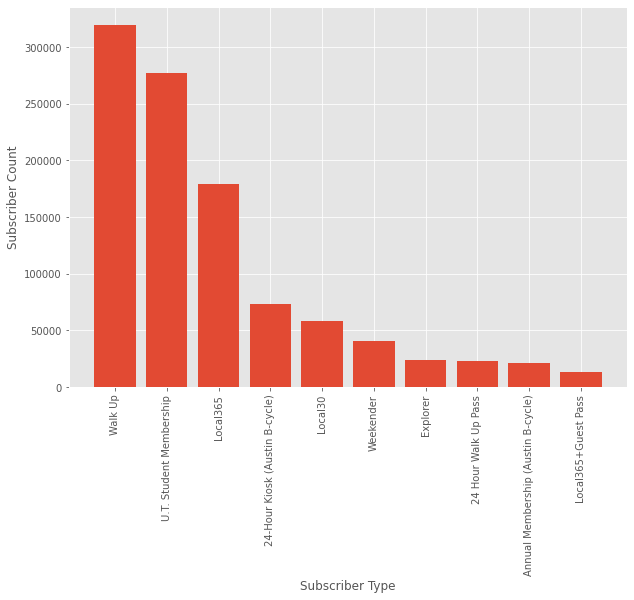

In [10]:
plt.style.use('ggplot')
subscriber_types = top10_subscribers['subscriber_type']
subscriber_counts = top10_subscribers['subscrber_count']

x_pos = [i for i, _ in enumerate(subscriber_types)]
plt.figure(figsize=(10,7))
plt.bar(x_pos, subscriber_counts)
plt.xticks(x_pos, subscriber_types, rotation=90)
plt.xlabel("Subscriber Type")
plt.ylabel("Subscriber Count")
plt.show()

Now lets look at Top 10 used bike stations

In [11]:
top10_used_stations = client.query('''SELECT
  a.station_id, a.name, latitude, longitude, COUNT(trip_id) AS no_of_trips
FROM
  `bigquery-public-data.austin_bikeshare.bikeshare_stations` a,
  `bigquery-public-data.austin_bikeshare.bikeshare_trips` b
WHERE
  a.station_id = b.start_station_id
  AND a.status = 'active'
  AND b.end_station_id NOT IN ('Event')
  AND b.subscriber_type IS NOT NULL
GROUP BY
  a.station_id, a.name, latitude, longitude
ORDER BY
  no_of_trips DESC
LIMIT
  10''').to_dataframe()

In [12]:
top10_used_stations.head()

,station_id,name,latitude,longitude,no_of_trips
0,3798,21st & Speedway @PCL,30.28300,-97.73750,75690
1,2575,Riverside @ S. Lamar,30.26446,-97.75665,42962
2,2707,Rainey St @ Cummings,30.25579,-97.73982,37424
3,2499,City Hall / Lavaca & 2nd,30.26476,-97.74678,36913
4,2494,2nd & Congress,30.26408,-97.74355,35954


Visualize top 10 stations with Bar Chart

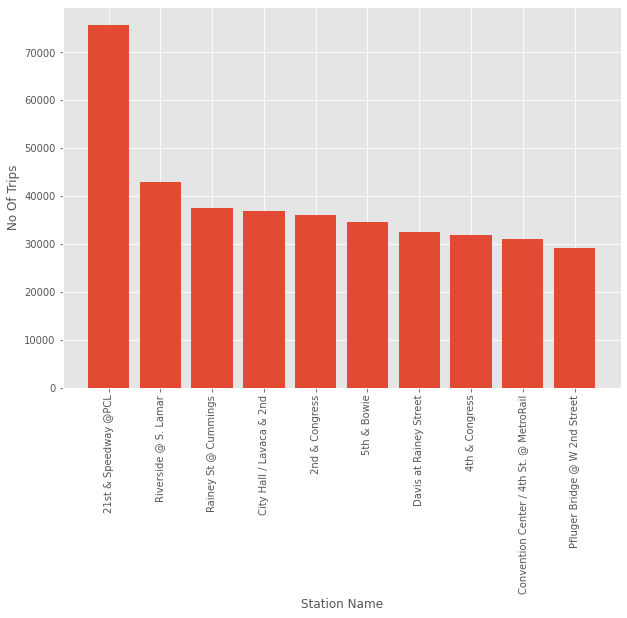

In [13]:
plt.style.use('ggplot')
station_names = top10_used_stations['name']
no_of_trips = top10_used_stations['no_of_trips']

x_pos = [i for i, _ in enumerate(station_names)]
plt.figure(figsize=(10,7))
plt.bar(x_pos, no_of_trips)
plt.xticks(x_pos, station_names, rotation=90)
plt.xlabel("Station Name")
plt.ylabel("No Of Trips")
plt.show()

Lets look at where these stations located in Austin are using the Google Maps API

In [51]:
map = '<img src="https://maps.googleapis.com/maps/api/staticmap?'
map = map + 'center=30.28300,-97.73750&zoom=13&size=1024x768'
map = map + '&maptype=roadmap'
for index, station in top10_used_stations.iterrows():
  map = map + '&markers=color:blue%7Clabel:S%7C' + str(station['latitude']) + ',' + str(station['longitude']) 
map = map + '&key=' + api_key + '"/>'

In [ ]:
map

In [53]:
from IPython.display import display, HTML
display(HTML(map))